# CNN using Pytorch on the astar dataset
Goal is to use CNNs to solve the supervised learning problem for finding the correct class label for the astar dataset

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [85]:
# First let's load the dataset
from datasets.astar_dataset import make_astar_dataset
import time


# Set the grid size here
n, m = 32, 32  # grid size for the problem
N = 100000     # Number of examples

# Probability of existence of obstacle
obstacle_probability = 0.34


# Create the data set
start = time.time()
X, y = make_astar_dataset(N, n, m, obstacle_probability)
print(f"Execution time: {time.time() - start:.4f} seconds")

Execution time: 30.3174 seconds


In [86]:
import pandas as pd

# Print the statistics of each class label
y_df = pd.DataFrame(y)  # Convert y to a pandas Series if it's not already
y_df.describe()

,0,1,2,3,4
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.194980,0.194980,0.194980,0.194980,0.220080
std,0.396187,0.396187,0.396187,0.396187,0.414302
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [87]:
# Convert the labels from one_hot vector to integer indicies
y = np.argmax(y, axis=1) 

In [88]:
# Create a custom torch dataset
import torch
from torch.utils.data import Dataset, DataLoader

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()

# Create a custom dataset class to retrieve the data
class BinaryImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


# Create the dataset and dataloader classes

dataset = BinaryImageDataset(X_tensor, y_tensor)
trainloader = DataLoader(dataset, batch_size=4, shuffle=True)

torch.Size([3, 32, 32])
left


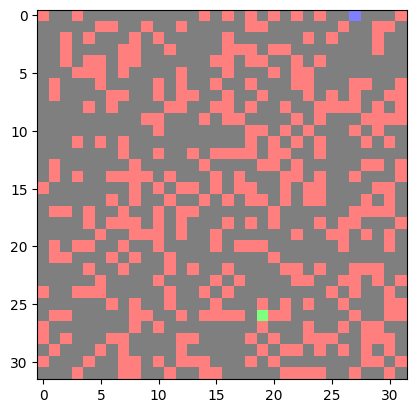

In [89]:
# Visualize some of the images
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Visualizing the dataset

classes = ("up", "left", "down", "right", "no_path")

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
images, labels = next(dataiter)

img = images[0]
label = labels[0].item()

print(img.shape)
# imshow(torchvision.utils.make_grid(images))
imshow(img)

print(classes[label])


In [90]:
# Let's now create a network that can solve this problem
import torch.nn as nn
import torch.nn.functional as F

class AstarNetwork(nn.Module):
    def __init__(self):
        super(AstarNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = AstarNetwork()
net(img)

tensor([[-0.0649,  0.0479, -0.0978, -0.0663, -0.0588,  0.0277,  0.0153, -0.0406,
          0.0507,  0.0719]], grad_fn=<AddmmBackward0>)

In [91]:
import torch.optim as optim
# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss() # The cross entropy loss for classification
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train
for epoch in range(2): # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # Zero gradient here is an important step
        # Gradients are accumulated over a batch, if we don't reset the gradient here we will keep accumulating gradients
        # making it impossible to train
        optimizer.zero_grad() 

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # Compute the gradients that will direct the learning
        optimizer.step() # actually learn (one learning step)

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 minibatches
            print(f"[{epoch}, {i}] loss: {running_loss / 2000}")
            running_loss = 0.0

[0, 1999] loss: 1.696083959043026
[0, 3999] loss: 1.626701900601387
[0, 5999] loss: 1.622014418542385
[0, 7999] loss: 1.6203924247026444
[0, 9999] loss: 1.6193595696091652
[0, 11999] loss: 1.6178075722455978
[0, 13999] loss: 1.617359654545784
[0, 15999] loss: 1.6176541901230812
[0, 17999] loss: 1.6161127519607543
[0, 19999] loss: 1.6161269274950028
[0, 21999] loss: 1.6156476418972014
[0, 23999] loss: 1.6164099154472351
[1, 1999] loss: 1.6142184123396874
[1, 3999] loss: 1.6148822720050813
[1, 5999] loss: 1.6130842953324318
[1, 7999] loss: 1.6138817499876021
[1, 9999] loss: 1.6136884601116182
[1, 11999] loss: 1.6139769847393035
[1, 13999] loss: 1.613466708779335
[1, 15999] loss: 1.6136337931752205
[1, 17999] loss: 1.6120574041604996
[1, 19999] loss: 1.6114340067505837
[1, 21999] loss: 1.6126478654146195
[1, 23999] loss: 1.6116077530384063
